# Hands-on 1: How to create a fMRI preprocessing workflow

### Preprocessing workflow
Here we list the interfaces we want to use in our workflow and the order we will execute them in.

1. Gunzip (Nipype)
2. Drop Dummy Scans (FSL)
3. Slice Time Correction (SPM)
4. Motion Correction (SPM)
5. Artifact Detection
6. Segmentation (SPM)
7. Coregistration (FSL)
8. Smoothing (FSL)
9. Apply Binary Mask (FSL)
10. Remove Linear Trends (Nipype)

### Package Imports

In [6]:
# Node and workflow objects
from nipype import Node, Workflow

# Specify which SPM to use
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('/opt/spm12-r7219/spm12_mcr/spm12')

200814-20:21:24,546 nipype.utils WARNING:
	 A newer version (1.5.0) of nipy/nipype is available. You are using 1.5.0-rc1.post-dev


Normally it would be correct to put all of our imports here at the top, however as this is a tutorial we will import them at each relevant step so that we can see where each piece fits in.

### Workflow
Nipype recommend creating a workflow later in a script so that everything is together. We can initialize it here now, then fill it out as we go.

We use the 'base_dir' to specify where we want to store the working directory.

In [7]:
preproc = Workflow(name='work_preproc', base_dir='/output/')

### Gunzip
We can use the Gunzip node as a template for other nodes. We can also specify here an 'in_file' so that we can directly test the nodes without worrying about the Input/Output data stream to the workflow which will be taken care of in a later section.

In [8]:
from nipype.algorithms.misc import Gunzip

In [9]:
# Here we specify an example input file
func_file = '/data/sub-01/func/sub-01_task-rest_bold.nii.gz'

# Now we can initiate Gunzup node
gunzip_func = Node(Gunzip(in_file=func_file), name='gunzip_func')

### Drop Dummy Scans

Now we can look and see what dummy scans are in the front of our functional images.

To illustrate this we can plot the time course of a random voxel of our func_file we just defined.

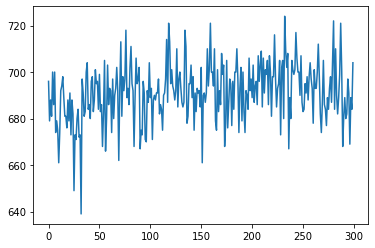

In [10]:
%matplotlib inline
import pylab as plt
import nibabel as nb
plt.plot(nb.load(func_file).get_fdata()[20, 20, 15, :]);

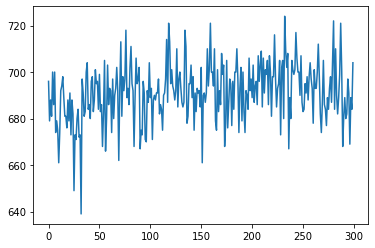

In [11]:
%matplotlib inline
import pylab as plt
import nibabel as nb
plt.plot(nb.load(func_file).get_fdata()[20, 20, 15, :]);

Based on these two random voxels it doesn't look like there are any extreme values, so we can skip the next step which would have been to use FSL's ExtractROI to delete dummy scans (we will just remove a few for the sake of example)

In [12]:
from nipype.interfaces.fsl import ExtractROI

While it doesn't look like there are any scans at the start that need to be removed, for the sake of example we will just remove the first 4 using the following command.

In [13]:
extract = Node(ExtractROI(t_min=4, t_size=-1, output_type='NIFTI'),
              name='extract')

This ExtractROI node can now be connected to the gunzip_func node from above, which we can do using the following command.

In [14]:
preproc.connect([(gunzip_func, extract, [('out_file', 'in_file')])])

### Slice Time Correction

For this step we can use SPMs SliceTiming to correct for slice wise acquisition of the volumes. When using BIDS data this can be found easily in one of the json files.

For our particular dataset (ds00135) the data was recorded with:
1. A time repetition (TR) of 2.13s
2. 32 slices per volume
3. Interleaved slice acquisition (bicommissural)
4. Time acquisition (TA) of 2.0634375 seconds i.e TR-(TR/num_slices)

In [15]:
from nipype.interfaces.spm import SliceTiming

Here we can use a nice python tool (range) to set our slice order. The first parameter is what you start on, the second is one more than what you want to finish on, the third parameter is the steps between numbers.

In [16]:
slice_order = list(range(1, 33, 2)) + list(range(2, 33, 2))
print(slice_order)

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32]


Now we can initiate our SliceTiming node here.

In [17]:
slicetime = Node(SliceTiming(num_slices=32,
                            ref_slice=16,
                            slice_order=slice_order,
                            time_repetition=2.13,
                            time_acquisition=2.0634375),
                            name='slicetime')

Now we want to connect our SliceTiming node to the rest of the workflow (i.e the ExtractROI node).

In [18]:
preproc.connect([(extract, slicetime, [('roi_file', 'in_files')])])

### Motion Correction

Here we need to correct for motion in the MRI scanner using FSL's MCFLIRT.

In [19]:
from nipype.interfaces.fsl import MCFLIRT

Now we can initiate MCFLIRT node here.

In [20]:
mcflirt = Node(MCFLIRT(mean_vol=True,
                      save_plots=True),
              name="mcflirt")

Now we can connect the MCFLIRT node to the rest of the workflow.

In [21]:
preproc.connect([(slicetime, mcflirt, [('timecorrected_files', 'in_file')])])

### Artifact Detection
Here we will use a tool ArtifactDetectino from Nipype to detect motion and intensity outliers in the functional images. The interface is initiated as follows.

In [22]:
from nipype.algorithms.rapidart import ArtifactDetect

In [23]:
art = Node(ArtifactDetect(norm_threshold=2,
                         zintensity_threshold=2,
                         mask_type='spm_global',
                         parameter_source='FSL',
                         use_differences=[True, False],
                         plot_type='svg'),
          name="art")



The parameters above mean the following:

1. norm_threshold - Threshold to use to detect motion-related outliers when composite motion is being used
2. zintensity_threshold - Intensity Z-threshold use to detection images that deviate from the mean
3. mask_type - Type of mask that should be used to mask the functional data. spm_global uses an spm_global like calculation to determine the brain mask
4. parameter_source - Source of movement parameters
5. use_differences - If you want to use differences between successive motion (first element) and intensity parameter (second element) estimates in order to determine outliers

Now we can connect this node to the rest of the workflow.

In [24]:
preproc.connect([(mcflirt, art, [('out_file', 'realigned_files'),
                                 ('par_file', 'realignment_parameters')])
                 ])

### Segmentation of anatomical image
Now we can work on an anatomical image, using SPMs NewSegment to create probability maps for the grey matter, white matter and CSF.

In [25]:
from nipype.interfaces.spm import NewSegment

In [26]:
# Use the following tissue specification to get a GM and WM probability map
tpm_img ='/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'
tissue1 = ((tpm_img, 1), 1, (True,False), (False, False))
tissue2 = ((tpm_img, 2), 1, (True,False), (False, False))
tissue3 = ((tpm_img, 3), 2, (True,False), (False, False))
tissue4 = ((tpm_img, 4), 3, (False,False), (False, False))
tissue5 = ((tpm_img, 5), 4, (False,False), (False, False))
tissue6 = ((tpm_img, 6), 2, (False,False), (False, False))
tissues = [tissue1, tissue2, tissue3, tissue4, tissue5, tissue6]

Now we can initiate the NewSegment node here.

In [27]:
segment = Node(NewSegment(tissues=tissues), name='segment')

We will again be using a Gunzip node to unzip the anatomical image that we then want to use as input to the segmentation node. We again also need to specify the anatomical image that we want to use in this case. As before, this will later also be handled directly by the Input/Output stream.

In [28]:
# Specify example input file
anat_file = '/data/sub-01/anat/sub-01_T1w.nii.gz'

# Initiate Gunzip node
gunzip_anat = Node(Gunzip(in_file=anat_file), name='gunzip_anat')

Now we can connect the NewSegment node to the rest of the workflow.

In [29]:
preproc.connect([(gunzip_anat, segment, [('out_file', 'channel_files')])])

### Compute Cooregistration Matrix

As a next step, we will make sure that the functional images are coregistered to the anatomical image. For this, we will use FSL's FLIRT function. As we just created a white matter probability map, we can use this together with the a Boundary-Based Registration (BBR) cost function do optimize the image coregistration. As some helpful notes...

1. use a degree of freedom of 6
2. specify the cost function as bbr
3. use the schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch'


In [30]:
from nipype.interfaces.fsl import FLIRT

In [31]:
coreg = Node(FLIRT(dof=6,
                   cost='bbr',
                   schedule='/usr/share/fsl/5.0/etc/flirtsch/bbr.sch',
                   output_type='NIFTI'),
             name="coreg")

Now we connect FLIRT node to the other nodes here.

In [32]:
preproc.connect([(gunzip_anat, coreg, [('out_file', 'reference')]),
                 (mcflirt, coreg, [('mean_img', 'in_file')])
                 ])

As mentioned above, the bbr routine can use the subject-specific white matter probability map to guide the coregistration. But for this, we need to create a binary mask out of the WM probability map. This can easily be done by FSL's Threshold interface.

In [33]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold WM probability image
threshold_WM = Node(Threshold(thresh=0.5,
                              args='-bin',
                              output_type='NIFTI'),
                name="threshold_WM")

Now, to select the WM probability map that the NewSegment node created, we need some helper function. Because the output field partial_volume_files form the segmentation node, will give us a list of files, i.e. [[GM_prob], [WM_prob], [], [], [], []]. Therefore, using the following function, we can select only the last element of this list.

In [34]:
# Select WM segmentation file from segmentation output
def get_wm(files):
    return files[1][0]

# Connecting the segmentation node with the threshold node
preproc.connect([(segment, threshold_WM, [(('native_class_images', get_wm),
                                           'in_file')])])

Now we can just connect this Threshold node to the coregistration node from above.

In [35]:
preproc.connect([(threshold_WM, coreg, [('out_file', 'wm_seg')])])

### Apply Cooregistration Matrix to Functional Image
Now that we know the coregistration matrix to correctly overlay the funtional mean image on the subject-specific anatomical image, we can apply coregistration to the whole time series. This can be done with FSL FLIRT.

In [36]:
# Specify the isometric voxel resolution you want after coregistration
desired_voxel_iso = 4

# Apply coregistration warp to functional images
applywarp = Node(FLIRT(interp='spline',
                       apply_isoxfm=desired_voxel_iso,
                       output_type='NIFTI'),
                 name="applywarp")

<font color='red'>Important</font>: As you can see above, we also specified a variable desired_voxel_iso. This is very important at this stage, otherwise FLIRT will transform your functional images to a resolution of the anatomical image, which will dramatically increase the file size (e.g. to 1-10GB per file). If you don't want to change the voxel resolution, use the additional parameter no_resample=True. Important, for this to work, you still need to define apply_isoxfm=desired_voxel_iso.

In [37]:
# Connecting the ApplyWarp node to all the other nodes
preproc.connect([(mcflirt, applywarp, [('out_file', 'in_file')]),
                 (coreg, applywarp, [('out_matrix_file', 'in_matrix_file')]),
                 (gunzip_anat, applywarp, [('out_file', 'reference')])
                 ])

### Smoothing
Next step is image smoothing, the most simple way to do this is using fSL SUSAN workflow as implemented inNipype. For this to work we need to import a workflow instead of an interface.

In [38]:
from nipype.workflows.fmri.fsl.preprocess import create_susan_smooth

200814-20:22:13,233 nipype.interface INFO:
	 We advise you to upgrade DIPY version. This upgrade will open access to more function
200814-20:22:13,237 nipype.interface INFO:
	 We advise you to upgrade DIPY version. This upgrade will open access to more function
200814-20:22:13,240 nipype.interface INFO:
	 We advise you to upgrade DIPY version. This upgrade will open access to more models


/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/niflow/nipype1/workflows/dmri/mrtrix/group_connectivity.py:16: UserWarning: cmp not installed
  warnings.warn('cmp not installed')
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/nipype/workflows/__init__.py:28: UserWarning: Nipype 1 workflows have been moved to the niflow-nipype1-workflows package. nipype.workflows.* provides a reference for backwards compatibility. Please use niflow.nipype1.workflows.* to avoid this warning.
  warnings.warn(" ".join(_msg))


If you type create_susan_smooth? you can see how to specify the input variables to the susan workflow. In particular, they are

1. fwhm: set this value to 4 (or whichever value you want)
2. mask_file: will be created in a later step
3. in_file: will be handled while connection to other nodes in the preproc workflow

Now we need to initiate the SUSAN workflow here

In [39]:
susan = create_susan_smooth(name='susan')
susan.inputs.inputnode.fwhm = 4

Connect threshold node to coregistration node above here.

In [40]:
preproc.connect([(applywarp, susan, [('out_file', 'inputnode.in_files')])])

### Create a binary mask
There are many possible approaches on how you can ask your functional images. For this example we will create a dilated grey matter mask which means we need to:
1. resample grey matter probability map to the same resolution as functional images
2. Threshold this resampled probability map at a specific value
3. Dilate this mask by some voxels to make the mass less conservative and more inclusive.

The first step can be done in many ways (eg. using freesurfer's mri_convert, nibabel) but in our case, we will use FSL's FLIRT. The trick is to use the probability mask, as input file and a reference file.

In [41]:
from nipype.interfaces.fsl import FLIRT

# Initiate resample node
resample = Node(FLIRT(apply_isoxfm=desired_voxel_iso,
                      output_type='NIFTI'),
                name="resample")

The second and third steps can be done with just one node as follows.

In [42]:
from nipype.interfaces.fsl import Threshold

# Threshold - Threshold GM probability image
mask_GM = Node(Threshold(thresh=0.5,
                         args='-bin -dilF',
                         output_type='NIFTI'),
                name="mask_GM")

# Select GM segmentation file from segmentation output
def get_gm(files):
    return files[0][0]

Now we can connect the resample and the gray matter mask node to the segmentation node and each other.

In [43]:
preproc.connect([(segment, resample, [(('native_class_images', get_gm), 'in_file'),
                                      (('native_class_images', get_gm), 'reference')
                                      ]),
                 (resample, mask_GM, [('out_file', 'in_file')])
                 ])

### Apply the binary mask
Now we can connect this dilated grey matter mask to the susan node as well as applying this to the smoothed images.

In [44]:
preproc.connect([(mask_GM, susan, [('out_file', 'inputnode.mask_file')])])

To apply the mask to the smoothed functional images, we will use FSL's ApplyMask interface.

In [45]:
from nipype.interfaces.fsl import ApplyMask

mportant: The susan workflow gives out a list of files, i.e. [smoothed_func.nii] instead of just the filename directly. If we would use a normal Node for ApplyMask this would lead to an error.

To prevent this we will be using a MapNode and specify the in_file as it's iterfield. Like this, the node is capable to handle a list of inputs as it will know that it has to apply itself iteratively to the list of inputs.

In [46]:
from nipype import MapNode

In [47]:
mask_func = MapNode(ApplyMask(output_type='NIFTI'),
                    name="mask_func",
                    iterfield=["in_file"])

In [48]:
preproc.connect([(susan, mask_func, [('outputnode.smoothed_files', 'in_file')]),
                 (mask_GM, mask_func, [('out_file', 'mask_file')])
                 ])

### Remove Linear Trends in Func Images

Last but not least. Let's use Nipype's TSNR module to remove linear and quadratic trends in the functionally smoothed images. For this, you only have to specify the regress_poly parameter in the node initiation.

In [49]:
from nipype.algorithms.confounds import TSNR

Now we initialize the TSNR node here.

In [50]:
detrend = Node(TSNR(regress_poly=2), name="detrend")

Now we connect to our other nodes.

In [51]:
preproc.connect([(mask_func, detrend, [('out_file', 'in_file')])])

### Datainput with Selectfiles and Iterables
This is all nice and well. But so far we still had to specify the input values for gunzip_anat and gunzip_func ourselves. How can we scale this up to multiple subjects and/or multiple functional images and make the workflow take the input directly from the BIDS dataset?

For this, we need SelectFiles and iterables! It's rather simple, specify a template and fill-up the placeholder variables.

In [52]:
# Import the SelectFiles
from nipype import SelectFiles

# String template with {}-based strings
templates = {'anat': 'sub-{subject_id}/anat/sub-{subject_id}_T1w.nii.gz',
             'func': 'sub-{subject_id}/func/sub-{subject_id}_task-rest_bold.nii.gz'}

# Create SelectFiles node
sf = Node(SelectFiles(templates,
                      base_directory='/home/neuro/nipype_tutorial/data/ds001354/',
                      sort_filelist=True),
          name='selectfiles')

Now we can specify over which subjects the workflow should iterate.

This next cell is the bit that I am not sure about
as it has deviated a bit from the example
If something goes wrong I might have to come back here 
and work to find a solution or simplify the file structure

In [53]:
#subject_list = ['01', '02','03', '04','05', '06',
#                '07', '08','09', '10','11', '12',
#               '13', '14', '15', '16', '17', '18',
#               '19', '20', '21', '22', '23', '24',
#               '25', '26', '27', '28']

subject_list = ['01', '02', '03']
sf.iterables = [('subject_id', subject_list)]

Now we can connect SelectFiles node to the other nodes.

In [54]:
preproc.connect([(sf, gunzip_anat, [('anat', 'in_file')]),
                 (sf, gunzip_func, [('func', 'in_file')])])

### Vizualise the workflow
First we can create the preproc output graph.

200814-20:22:44,958 nipype.workflow INFO:
	 Generated workflow graph: /output/work_preproc/graph.png (graph2use=colored, simple_form=True).


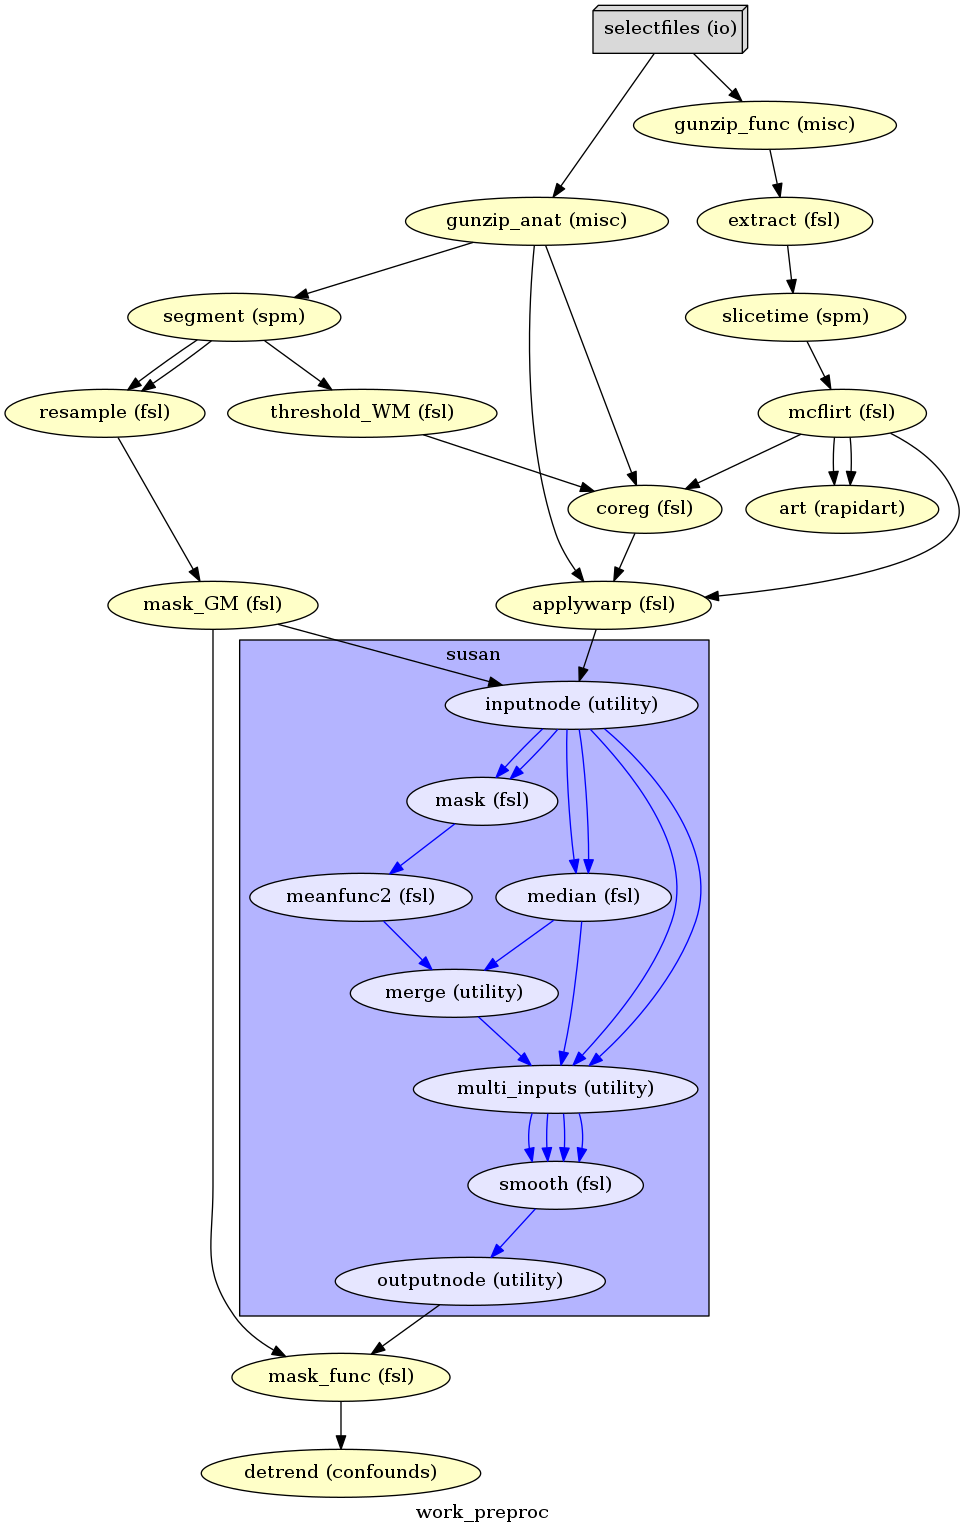

In [55]:
preproc.write_graph(graph2use='colored', format='png', simple_form=True)

from IPython.display import Image
Image(filename='/output/work_preproc/graph.png', width=750)

### Run the workflow
Now we are ready to run our workflow. We have to be careful about the n_procs parameter if we run a workflow in 'Multiproc' mode as this defines the number of jobs/cores we use. Too high and a computer will likely crash.

Note: If you're using a Docker container and FLIRT fails to run without any good reason, you might need to change memory settings in the Docker preferences (6 GB should be enough for this workflow).

In [51]:
preproc.run('MultiProc', plugin_args={'n_procs': 3})

200814-18:46:02,634 nipype.workflow INFO:
	 Workflow work_preproc settings: ['check', 'execution', 'logging', 'monitoring']
200814-18:46:02,800 nipype.workflow INFO:
	 Running in parallel.
200814-18:46:02,809 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 3 jobs ready. Free memory (GB): 5.24/5.24, Free processors: 3/3.
200814-18:46:02,900 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/output/work_preproc/_subject_id_03/selectfiles".200814-18:46:02,908 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/output/work_preproc/_subject_id_02/selectfiles".200814-18:46:02,906 nipype.workflow INFO:
	 [Node] Setting-up "work_preproc.selectfiles" in "/output/work_preproc/_subject_id_01/selectfiles".


200814-18:46:03,13 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")200814-18:46:03,13 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")200814-18:46:03,15 nipyp

### Inspect Output
To see if this has worked correctly, we need to look at some of the data that we created.

In [5]:
!tree /output/work_preproc/ -I '*js|*json|*pklz|_report|*dot|*html|*txt|*.m'

/output/work_preproc/
├── graph.png
├── _subject_id_01
│   ├── applywarp
│   │   ├── asub-01_task-rest_bold_roi_mcf_flirt.mat
│   │   └── asub-01_task-rest_bold_roi_mcf_flirt.nii
│   ├── art
│   │   ├── mask.asub-01_task-rest_bold_roi_mcf.nii.gz
│   │   └── plot.asub-01_task-rest_bold_roi_mcf.svg
│   ├── coreg
│   │   ├── asub-01_task-rest_bold_roi_mcf.nii.gz_mean_reg_flirt.mat
│   │   └── asub-01_task-rest_bold_roi_mcf.nii.gz_mean_reg_flirt.nii
│   ├── extract
│   │   └── sub-01_task-rest_bold_roi.nii
│   ├── gunzip_anat
│   │   └── sub-01_T1w.nii
│   ├── gunzip_func
│   │   └── sub-01_task-rest_bold.nii
│   ├── mask_GM
│   │   └── c1sub-01_T1w_flirt_thresh.nii
│   ├── mcflirt
│   │   ├── asub-01_task-rest_bold_roi_mcf.nii.gz
│   │   ├── asub-01_task-rest_bold_roi_mcf.nii.gz_mean_reg.nii.gz
│   │   └── asub-01_task-rest_bold_roi_mcf.nii.gz.par
│   ├── resample
│   │   ├── c1sub-01_T1w_flirt.mat
│   │   └── c1sub-01_T1w_flirt.nii
│   ├── segment
│   │   ├── c1sub-01_T1w.nii
│   │   ├──

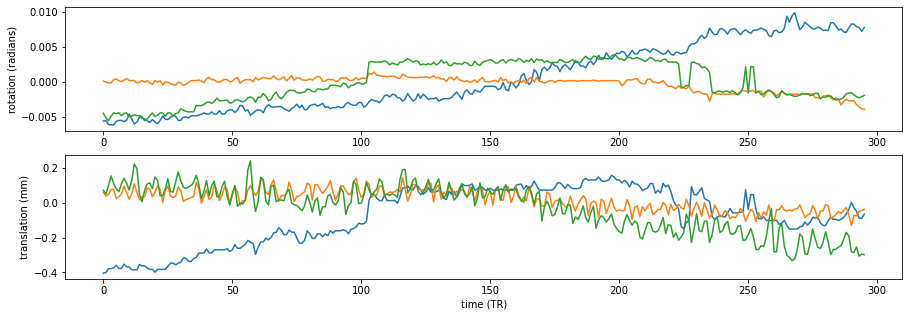

In [56]:
%matplotlib inline

# Plot the motion paramters
import numpy as np
import pylab as plt
par = np.loadtxt('/output/work_preproc/_subject_id_01/mcflirt/'
                 'asub-01_task-rest_bold_roi_mcf.nii.gz.par')
fig, axes = plt.subplots(2, 1, figsize=(15, 5))
axes[0].set_ylabel('rotation (radians)')
axes[0].plot(par[0:, :3])
axes[1].plot(par[0:, 3:])
axes[1].set_xlabel('time (TR)')
axes[1].set_ylabel('translation (mm)');

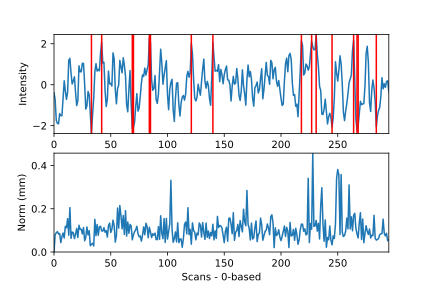

In [57]:
# Artifact detection output
from IPython.display import SVG
SVG(filename='/output/work_preproc/_subject_id_01/art/'
   'plot.asub-01_task-rest_bold_roi_mcf.svg')

From this we can make an assessment on what volumes are problematic.

In [58]:
outliers = np.loadtxt('/output/work_preproc/_subject_id_01/art/'
   'art.asub-01_task-rest_bold_roi_mcf_outliers.txt')
list(outliers.astype('int'))

[33, 42, 69, 70, 84, 85, 121, 140, 218, 227, 231, 245, 264, 267, 268, 284]

### Masks and Probability Maps
Now we can have a look at our masks to visually see whether we have done a good job.

In [59]:
from nilearn import image as nli
from nilearn.plotting import plot_stat_map
%matplotlib inline
output = '/output/work_preproc/_subject_id_01/'

Ok first let's look at the probability maps.

In [60]:
anat = output + 'gunzip_anat/sub-01_T1w.nii'

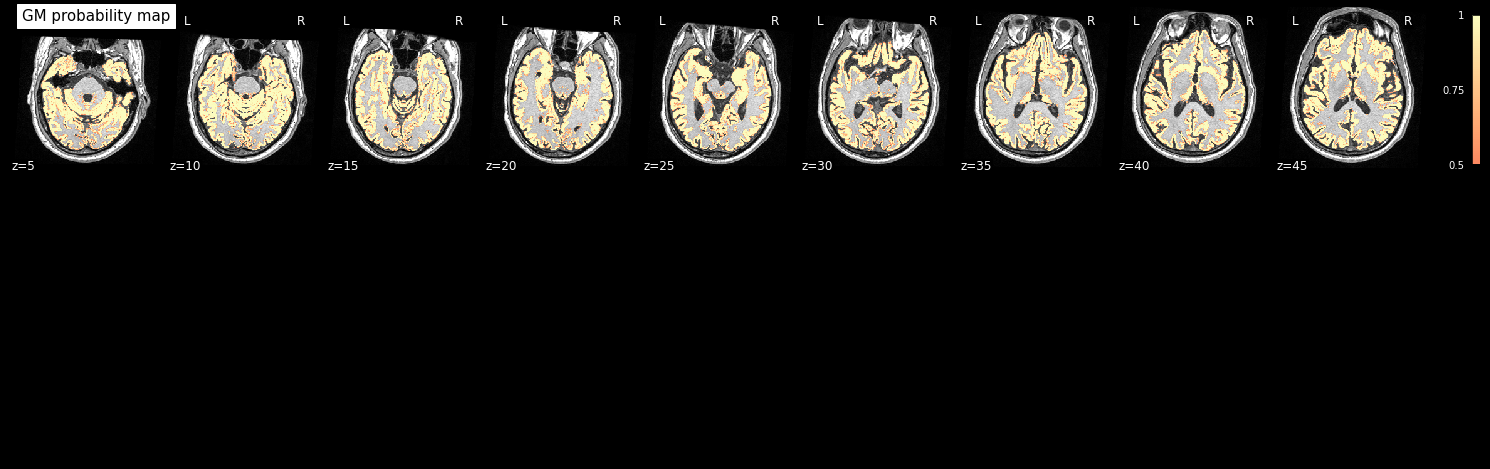

In [61]:
plot_stat_map(
output + 'segment/c1sub-01_T1w.nii', title='GM probability map', cmap=plt.cm.magma,
threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(5, 50, 5), dim=-1);

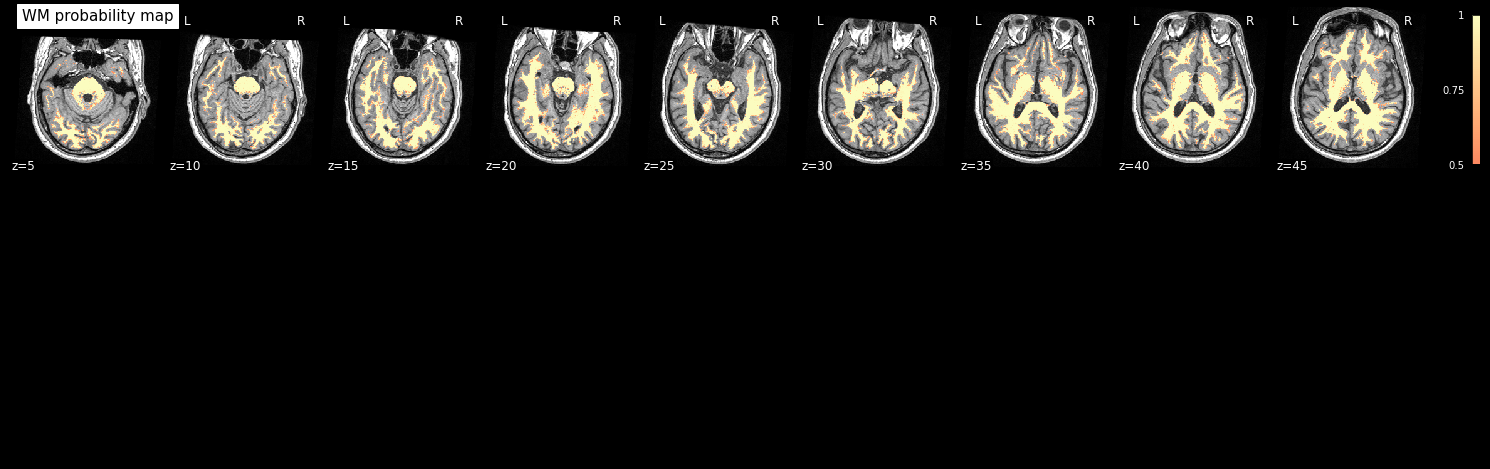

In [62]:
plot_stat_map(
output + 'segment/c2sub-01_T1w.nii', title='WM probability map', cmap=plt.cm.magma,
threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(5, 50, 5), dim=-1);

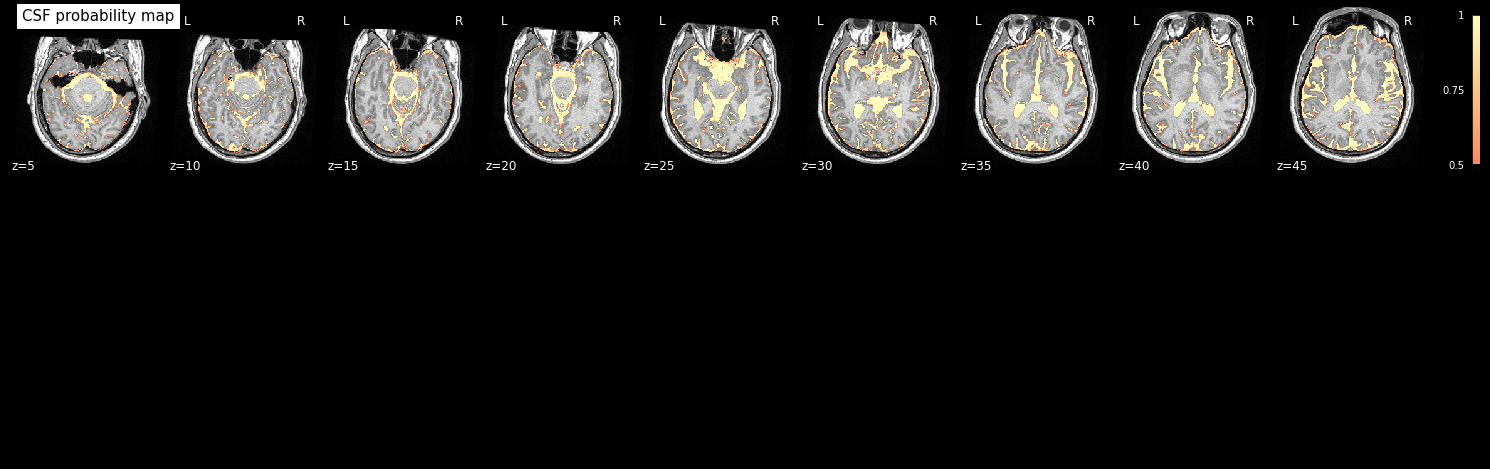

In [64]:
plot_stat_map(
output + 'segment/c3sub-01_T1w.nii', title='CSF probability map', cmap=plt.cm.magma,
threshold=0.5, bg_img=anat, display_mode='z', cut_coords=range(5, 50, 5), dim=-1);

### Functional image transformations
Now we can look at the transformation that we applied to the functional images.

In [65]:
%matplotlib inline
from nilearn import image as nli
from nilearn.plotting import plot_epi
output = '/output/work_preproc/_subject_id_01/'

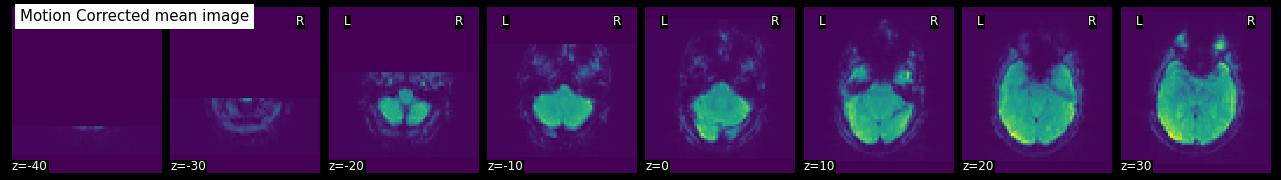

In [66]:
plot_epi(output + 'mcflirt/asub-01_task-rest_bold_roi_mcf.nii.gz_mean_reg.nii.gz',
         title='Motion Corrected mean image', display_mode='z', cut_coords=range(-40, 31, 10),
         cmap=plt.cm.viridis);

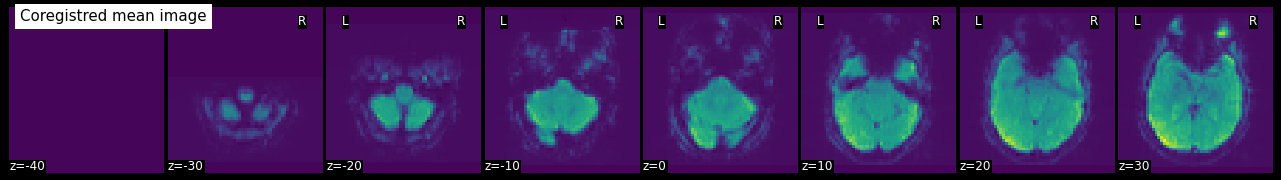

In [67]:
mean = nli.mean_img(output + 'applywarp/asub-01_task-rest_bold_roi_mcf_flirt.nii')
plot_epi(mean, title='Coregistred mean image', display_mode='z', cut_coords=range(-40, 31, 10),
         cmap=plt.cm.viridis);

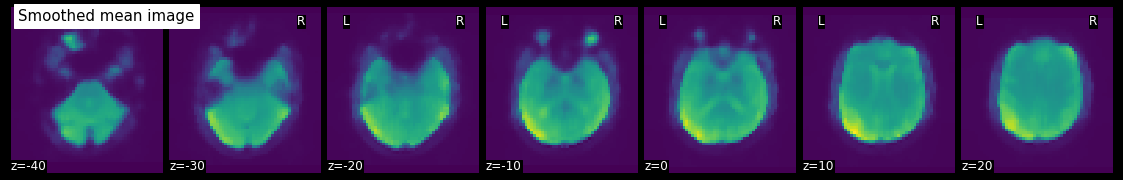

In [70]:
mean = nli.mean_img('/output/work_preproc/susan/_subject_id_02/smooth/mapflow/_smooth0/'
                    'asub-02_task-rest_bold_roi_mcf_flirt_smooth.nii.gz')
plot_epi(mean, title='Smoothed mean image', display_mode='z', cut_coords=range(-40, 21, 10),
         cmap=plt.cm.viridis);

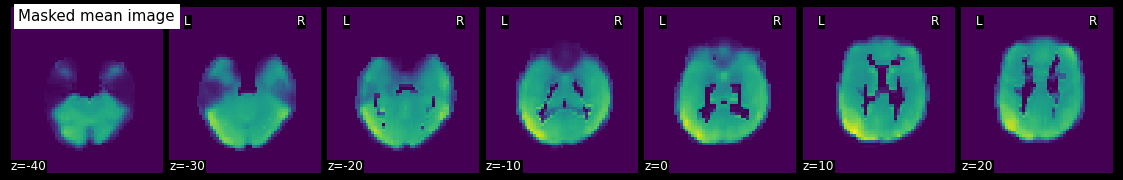

In [71]:
mean = nli.mean_img('/output/work_preproc/_subject_id_02/mask_func/mapflow/_mask_func0/'
                    'asub-02_task-rest_bold_roi_mcf_flirt_smooth_masked.nii')
plot_epi(mean, title='Masked mean image', display_mode='z', cut_coords=range(-40, 21, 10),
         cmap=plt.cm.viridis);

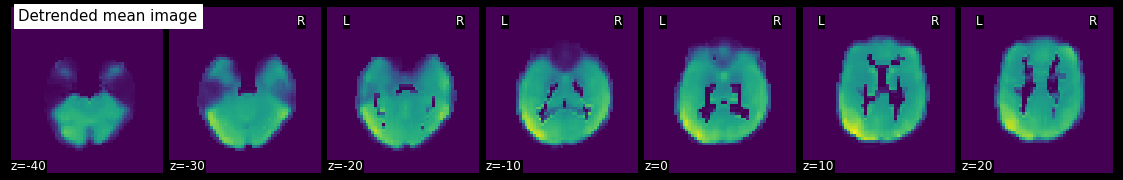

In [72]:
plot_epi('/output/work_preproc/_subject_id_02/detrend/mean.nii.gz', title='Detrended mean image', display_mode='z',
         cut_coords=range(-40, 21, 10), cmap=plt.cm.viridis);

This is all well and good (its not, look at all those errors, but for the sake of the tutorial we will continue on), but what did smoothing and detrending actually do to our data?

/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:14: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  from ipykernel import kernelapp as app
/opt/miniconda-latest/envs/neuro/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which h

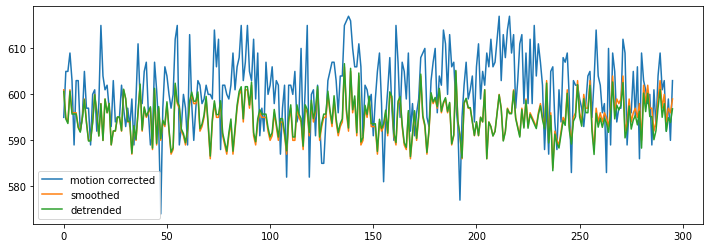

In [73]:
%matplotlib inline
import nibabel as nb
output = '/output/work_preproc/_subject_id_02/'

# Load the relevant datasets
mc = nb.load(output + 'applywarp/asub-02_task-rest_bold_roi_mcf_flirt.nii')
smooth = nb.load('/output/work_preproc/susan/_subject_id_02/smooth/mapflow/'
                 '_smooth0/asub-02_task-rest_bold_roi_mcf_flirt_smooth.nii.gz')
detrended_data = nb.load(output + 'detrend/detrend.nii.gz')

# Plot a representative voxel
x, y, z = 32, 34, 20
fig = plt.figure(figsize=(12, 4))
plt.plot(mc.get_data()[x, y, z, :])
plt.plot(smooth.get_data()[x, y, z, :])
plt.plot(detrended_data.get_data()[x, y, z, :])
plt.legend(['motion corrected', 'smoothed', 'detrended']);

### Data output with DataSink
If we run this without any more code we would get inundated with temporary files. So we can use DataSink to keep only those files we actually need for our first and second level analyses.

In [ ]:
from nipype.interfaces.io import DataSink

# Initiate the datasink node
output_folder = 'datasink_handson'
datasink = Node(DataSink(base_directory='/output/',
                        container=output_folder),
                        name='datasink')

Now the next step is to specify all the output that we want to keep in our output folder output. Make sure to keep:

    from the artifact detection node the outlier file as well as the outlier plot
    from the motion correction node the motion parameters
    from the last node, the detrended functional image

In [ ]:
preproc.connect([(art, datasink, [('outlier_files', 'preproc.@outlier_files'),
                                  ('plot_files', 'preproc.@plot_files')]),
                 (mcflirt, datasink, [('par_file', 'preproc.@par')]),
                 (detrend, datasink, [('detrended_file', 'preproc.@func')]),
                 ])

There are many unnecessary file specifiers that we can get rid off. To do so, we can use DataSink's substitutions parameter. For this, we create a list of tuples: on the left, we specify the string that we want to replace and on the right, with what we want to replace it with.

In [ ]:
## Use the following substitutions for the DataSink output
substitutions = [('asub', 'sub'),
                 ('_ses-test_task-fingerfootlips_bold_roi_mcf', ''),
                 ('.nii.gz.par', '.par'),
                 ]

# To get rid of the folder '_subject_id_07' and renaming detrend
substitutions += [('_subject_id_%s/detrend' % s,
                   '_subject_id_%s/sub-%s_detrend' % (s, s)) for s in subject_list]
substitutions += [('_subject_id_%s/' % s, '') for s in subject_list]
datasink.inputs.substitutions = substitutions